One of the most highlighted feature in tensorflow 2.x in the new dataset/tf.data api. It is suppose to simplify the data import/ preprocessing & caching to reduce required boiler-plate coding in the process. One more not so obvious features of the data api is that, it will also allow the data preprocessing pipelines to be part of the graph which will enable hardware accelaration for pipelines (hence speeding up the training) and second you can make them part of the model itself so that you wont need a seperate preprocessing service for model in production ( as in the whole thing can be served using just tensorflow serving! no need for a flask/ DRF wrapper around it)

In this notebook, i've tried to use some of the functions that tensorflow provides out of the box to build such pipelines. I'lll be using a fairly known dataset called 'cats-vs-dogs' (binary classification). The idea is to build image processing pipeline to prevent overfitting & to cirvumvent the issue of smaller training data.

In [0]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, regularizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

This is dataset is already available in tf dataset's catalog so importing it should be easy. Furthermore, due to small size of the dataset, there's only one split available for this dataset (TRAIN) so will be sub-splitting the TRAIN set into TRAIN & VALIDATION.

For subplitting, i've used tf.data's string API that lets us define slices using percentages! (easy as cake!)


In [0]:
  ds_train, info_train = tfds.load('cats_vs_dogs', split= 'train[:80%]', with_info= True)
  ds_val, info_val = tfds.load('cats_vs_dogs', split= 'train[:-20%]', with_info= True)

Once the data is downloaded (which happens only once, for later loading it will cache), we can build a basic pipeline function(fancy word for a map fucntion in tf.data api) which will get image & labels out of the dataset. (if you need info on dataset you can simply print the info object given by the load function)

In [7]:
def pipeline_fn_raw(inputs):
  image = inputs['image']
  label = inputs['label']
  return (image, label)

x1, y1 = next( iter(ds_val.map(pipeline_fn_raw).take(1)))
print('sample:',x1.shape,'label:',y1.shape)

sample: (262, 350, 3) label: ()


Now, this was fairly simple pipeline function, i've simple copied the data from 1 TFRecord & return it as a pair of data & label. Now i can build little more complex pipeline which lets ajusts the brighness of the image

In [0]:
def pipeline_fn_1(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.adjust_brightness(image, delta=0.4)
  return (image, label)

Here i've used an ajdust_brightness function, which increases the brightness of an image b given delta in each channel (seperately) (refer to https://www.tensorflow.org/api_docs/python/tf/image/adjust_brightness for more info)

Now, to see how this new pipeline function is working, we can write a test fucntion which compare given pipeline functions to our previous raw pipeline fucntion.


In [0]:
def test_pipeline(pipeline_fn):
  image1,lbl = next(iter(ds_val.map(pipeline_fn_raw).take(1)))
  image2,lbl = next(iter(ds_val.map(pipeline_fn).take(1)))
  print(lbl.numpy())
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(image1)
  plt.subplot(1,2,2)
  plt.title('Aug image')
  plt.imshow(image2)

This test_pipeline functions takes new pipeline function (the one that needs to be tested) & compares it with previous raw pipeline by generating 1 sample using both the pipelines

Now, lets test how the new pipelines does as comapred to raw one

1


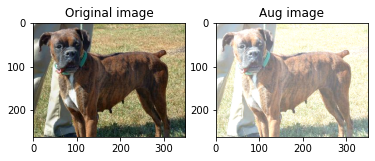

In [11]:
test_pipeline(pipeline_fn_1)

Well, that dog certainly fairer now!
Anyway lets try few more image processing functions 

1


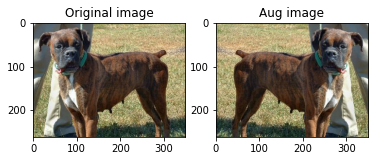

In [14]:
def pipeline_fn_2(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.flip_left_right(image)
  return (image, label)
test_pipeline(pipeline_fn_2)

Here i've flipped the image horizontally!
Lets try one last where we try to adjust hue of the image.

Similar to brightness, adjusting hue also requires a delta factor which controls the amount of change in each channel


1


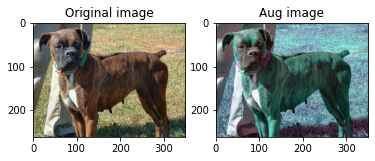

In [15]:
def pipeline_fn_3(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.adjust_hue(image, 0.4)
  return (image, label)
test_pipeline(pipeline_fn_3)

you can also chain such preprocessing fucntions together.

1


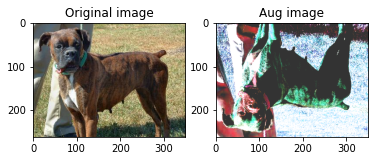

In [17]:
def pipeline_fn_4(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.flip_up_down(image)
  image = tf.image.adjust_contrast(image, contrast_factor=3)
  image = tf.image.adjust_brightness(image, delta=0.2)
  image = tf.image.adjust_hue(image, 0.4)
  return (image, label)
test_pipeline(pipeline_fn_4)

One more additional preprocessing function that i've used above is  `adjust_contrast` which as the name suggests, adjusts contrast based on a contrast_factor using formula:

 `(channel_data - mean) * contrast_factor + mean`

There are many more of such functions that you use from tensorflow tf.image module.


These functions are good but we want a pipeline function which performs these operations randomly on a given training batch so as to introduce variations (a.k.a. data augmentation )in in between epochs. This helps in avoiding overfitting (as model is not seeing the same sample again) & also mitigates the problem of smaller dataset.

To help with randomness, tensorflow provides random version of above functions.
Which basically means that preprocessing you define will be applied randomly to given batch.

For example:

1


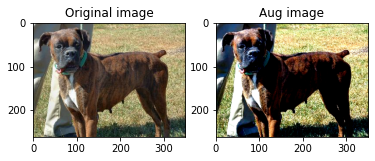

In [20]:
def pipeline_fn_5(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.random_contrast(image, lower=0.8, upper=3)
  image = tf.image.random_hue(image, max_delta=0.1)
  image = tf.image.random_flip_left_right(image)
  return (image, label)

test_pipeline(pipeline_fn_5)

Now if you notice, some of the parameters in these random functions are replaced by the bounds of the actual parameter as opposed to an actual value.

For example: in brighness, you define `max_delta` i.e. at runtime tf will adjust brightness randomly with delta chosen randomly between `0` & `max_delta`.

You can find more information these random fucntions at https://www.tensorflow.org/api_docs/python/tf/image


Now, lets define an actual pipeline that we can use for cats-vs-dogs.
One of the problem with this dataset is all the images do not have same size. These images vary in sizes & apsect ratio but we need every image to be in same size. So lets define a constant image width & height for our model.

In [0]:
IMAGE_WIDTH = 250
IMAGE_HEIGHT = 250

In order to actually bring images down to a fixed size we can use function `tf.image.resize_with_crop_or_pad` . If the image is larger than the size required, it takes a random crop out of it and if an image is smaller, then function applies padding to bring it down to the required size. (BTW this functionality is applied seperately to height & width of an image)

One last thing that we have to take care of is the actual RGB values of the image. we have to normalize them so that they will nicely fit in the range `[0, 1]` <br>To do that, we can use `tf.image.convert_image_dtype` function. As the name suggest, it casts the values to the given data type & then applies normalization. If you specify `int32` data-type it will normalize the values to `[0, MAX]` and for `float32` it will normalize them to `[0,1]
`


1
1


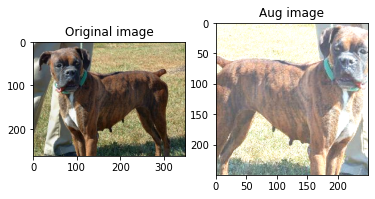

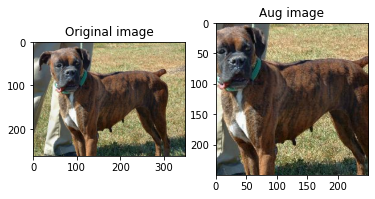

In [10]:

def image_pipeline_train(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.random_brightness(image, max_delta=0.5)
  image = tf.image.random_contrast(image, lower=0.8, upper=3)
  # image = tf.image.random_hue(image, max_delta=0.1)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize_with_crop_or_pad(image, target_height= IMAGE_HEIGHT, target_width= IMAGE_WIDTH)
  #lastly normalize the image
  image = tf.image.convert_image_dtype(image, tf.float32)
  return (image, label)

def image_pipeline_prod(inputs):
  image = inputs['image']
  label = inputs['label']
  image = tf.image.resize_with_crop_or_pad(image, target_height= IMAGE_HEIGHT, target_width= IMAGE_WIDTH)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return (image, label)

test_pipeline(image_pipeline_train)
test_pipeline(image_pipeline_prod)

We dont need any random preprocessing function for the validation/ production pipeline as it will be used for testing or serving only.<br/>

**Now that the pipeline functiosn are ready, we can define a model for classifying the images. I've used `3x3` kernel with increasing filters follwed by a `maxpool`.**
Once the conv+maxpool brings down the data represenatation to a small enough size, we can flatten it & feed to a bunch of dense layers.

In [11]:
def model_fn():
  layer_input = layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype='float32')     #(250, 250,3)
  a = layers.Conv2D(filters = 16, kernel_size= 3, activation='relu')(layer_input) #(248, 248,16)
  a = layers.MaxPooling2D(pool_size=(2,2), strides= 2)(a)                         #(124, 124,16)
  a = layers.Conv2D(filters = 32, kernel_size= 3, activation='relu')(a)           #(122, 122,32)
  a = layers.MaxPooling2D(pool_size=(2,2), strides= 2)(a)                         #(61, 61,32)
  a = layers.Conv2D(filters = 64, kernel_size= 3, activation='relu')(a)           #(59, 59,64)
  a = layers.MaxPooling2D(pool_size=(2,2), strides= 2)(a)                         #(29, 29,64)
  a = layers.Flatten()(a) #53824
  a = layers.Dense(units = 256, activation='relu')(a)
  a = layers.Dense(1, activation='sigmoid')(a)
  model = models.Model(layer_input, a)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  return model

model = model_fn()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0     

With pipeline functions, we can build our ene-to-end pipeline for training. This pipeline will be responsible for <br/>
`reading the data -> caching -> shuffling -> image-preprocessing -> batching -> prefetching`

All these functionalities can be implmented using functions of same name available in tf.data API. these functions can be chained together to create a pipeline. The end result of this pipeline looks something like *.NET's linq code* (sry i couldn't think of any python terminology). <br/>

Few tips on this chain:


*   Always put shuffle before caching, else shuffling will happen only once & model will same combination of data in every epoch due to cache
*   If result of your preprocessing generates large amount of data which cannot fit in memory then put `cache` before `map` function
*   If you want the data augmentation to vary in each epoch, put `map` after cache
*   If your data-preprocessing is very time consuming & you dont want to re-calcuate if for each epoch, put `map` before `cache`
*   You can also define parallel calls to your map function to parallelize preprocessing computation. The num of such parallel calls can be either configured based on number of cores or it should be best left to TF to figure it out using `tf.data.experimental.AUTOTUNE` parameter.
*   `prefetch` will make sure that when the model is busy training with `i`th batch, pipeline can fetch `i+1`th batch so that no time is wasted
* number of batches to prefetch in advance can also be set using `tf.data.experimental.AUTOTUNE` parameter




Below i've created 2 pipelines. `ds_train_aug` for training (which has all the random image preprocessing) by chaning together multiple components. & second `ds_val` without any preprocessing (as it will be used for testin)<br/>

The i can start a model training using these two! With all these fancy pre-processing we shouldn't be having any overfitting at all.

In [14]:
ds_train, info_train = tfds.load('cats_vs_dogs', split= 'train[:80%]', with_info= True)
ds_val, info_val = tfds.load('cats_vs_dogs', split= 'train[:-20%]', with_info= True)

ds_train_aug = ds_train.cache().shuffle(1024)\
  .map(image_pipeline_train, num_parallel_calls= tf.data.experimental.AUTOTUNE)\
  .batch(32)\
  .prefetch(tf.data.experimental.AUTOTUNE)

ds_val = ds_val.map(image_pipeline_prod).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

model = model_fn()
history = model.fit(ds_train_aug, epochs = 15, validation_data= ds_val).history

ERROR! Session/line number was not unique in database. History logging moved to new session 63
Epoch 1/15
582/582 [==============================] - 77s 133ms/step - loss: 0.6762 - acc: 0.5915 - val_loss: 0.6071 - val_acc: 0.6814
Epoch 2/15
582/582 [==============================] - 68s 116ms/step - loss: 0.5959 - acc: 0.6773 - val_loss: 0.5534 - val_acc: 0.7166
Epoch 3/15
582/582 [==============================] - 68s 117ms/step - loss: 0.5366 - acc: 0.7271 - val_loss: 0.4888 - val_acc: 0.7697
Epoch 4/15
582/582 [==============================] - 68s 117ms/step - loss: 0.4909 - acc: 0.7595 - val_loss: 0.5008 - val_acc: 0.7516
Epoch 5/15
582/582 [==============================] - 68s 117ms/step - loss: 0.4456 - acc: 0.7903 - val_loss: 0.3992 - val_acc: 0.8271
Epoch 6/15
582/582 [==============================] - 68s 117ms/step - loss: 0.4008 - acc: 0.8181 - val_loss: 0.3753 - val_acc: 0.8384
Epoch 7/15
582/582 [==============================] - 68s 117ms/step - loss: 0.3621 - acc: 0.83

Well, there it is! <br/>
No overfitting. 
A history plot should confirm the same:

<function matplotlib.pyplot.show>

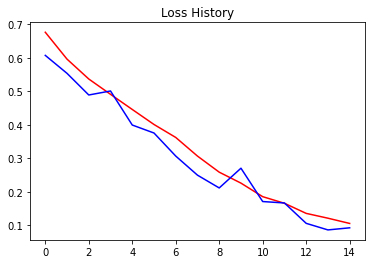

In [16]:
fig = plt.figure()
plt.plot(history['loss'], c='r')
plt.plot(history['val_loss'], c='b')
plt.title('Loss History')
plt.show

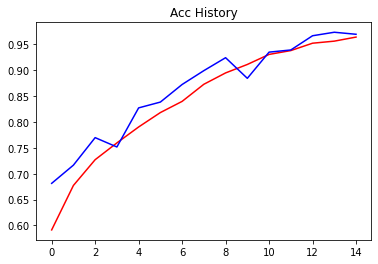

In [17]:
plt.plot(history['acc'], c='r')
plt.plot(history['val_acc'], c='b')
plt.title('Acc History')
plt.show()